# Find fit to SMF

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
np.set_printoptions(linewidth=1000)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

# Load data

Note that we can't use our normal data file because we have done some cuts on it.

In [4]:
datafile = "/home/christopher/Data/data/universe_machine/sfr_catalog_insitu_exsitu_0.712400_reduced_cols.npy"

In [5]:
data = np.load(datafile)

85019771
85019767
41031918


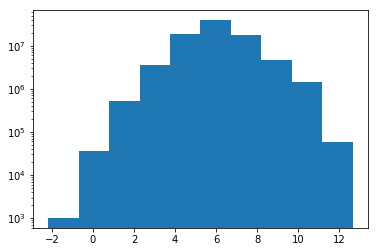

In [6]:
sm = data["sm"] + data["icl"]
print(len(sm))
sm = sm[sm != 0]
print(len(sm))
plt.hist(np.log10(sm), log=True)
sm = sm[sm > 1e6]
print(len(sm))

(array([1.6391591e+07, 1.0977647e+07, 6.2745400e+06, 3.5081400e+06, 1.7889540e+06, 1.0177300e+06, 7.1402500e+05, 3.3353400e+05, 2.5356000e+04, 4.0100000e+02]),
 array([ 6.00000434,  6.66541578,  7.33082723,  7.99623867,  8.66165011,  9.32706155,  9.99247299, 10.65788444, 11.32329588, 11.98870732, 12.65411876]),
 <a list of 10 Patch objects>)

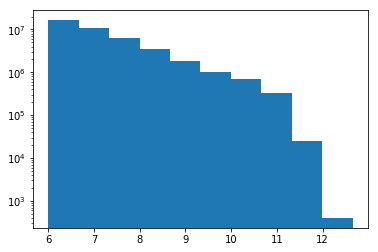

In [7]:
plt.hist(np.log10(sm), log=True)

# Write and test schecter funcs

In [144]:
# e.g. https://arxiv.org/pdf/1604.00008.pdf section 4, eq 9
def schechter_func(mass, m_star, alpha, phi_star):
    m_rat = mass / m_star
    return phi_star * np.exp(-m_rat) * m_rat**alpha


def integrated_schechter_func(mass0, mass1, mass, m_star, alpha, phi_star):
    return schechter_func(mass, m_star, alpha, phi_star) * (mass1 - mass0)
    
    
# e.g. https://arxiv.org/pdf/1604.00008.pdf section 4, eq 10
def log_schechter_func(mass, m_star, alpha, phi_star):
    mass, m_star, phi_star = 10**mass, 10**m_star, 10**phi_star
    
    m_rat = 10**(np.log10(mass) - np.log10(m_star))
    return np.log(10) * phi_star * np.exp(-m_rat) * m_rat**(alpha + 1)

    
# e.g. https://arxiv.org/pdf/1604.00008.pdf section 4, eq 10
def log_double_schechter_func(mass, m_star, alpha1, alpha2, phi_star1, phi_star2):
    mass, m_star, phi_star1, phi_star2 = 10**mass, 10**m_star, 10**phi_star1, 10**phi_star2

    m_rat = 10**(np.log10(mass) - np.log10(m_star))
    return np.log(10) * np.exp(-m_rat) * (
        phi_star1 * m_rat**(alpha1 + 1) +
        phi_star2 * m_rat**(alpha2 + 1))

def integrated_log_schechter_func(mass0, mass1, mass, m_star, alpha, phi_star):
    return log_schechter_func(mass, m_star, alpha, phi_star) * (
        np.log10(mass1) - np.log10(mass0))
# These appear to disagree but that might make sense.

In [9]:
mass, m_star, alpha, phi_star = 5e10, 1e10, 0.1, 0.1
s = schechter_func(mass, m_star, alpha, phi_star)
ls = log_schechter_func(mass, m_star, alpha, phi_star)

In [10]:
mass0, mass1 = 1e11, 2e11
ints = integrated_schechter_func(mass0, mass1, mass, m_star, alpha, phi_star)
intls = integrated_log_schechter_func(mass0, mass1, mass, m_star, alpha, phi_star)

In [11]:
print(s, ls)
print(ints, intls)

0.000791452018264886 0.009111928095383899
79145201.8264886 0.002742963675043924


# Fit

In [227]:
count, edges = np.histogram(np.log10(sm), bins=130)
centers  = edges[:-1] + (edges[1:] - edges[:-1])/2

x = 30
count = count[x:]
centers = centers[x:]
edges = edges[x:]

In [228]:
g_m_star, g_alpha, g_phi_star = 11.2, -1, 4

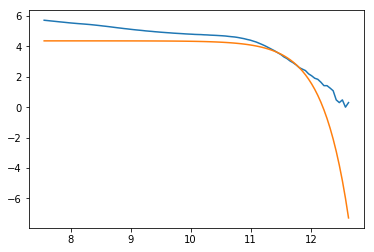

In [229]:
plt.plot(centers, np.log10(count))
plt.plot(centers, np.log10(
    log_schechter_func(centers, g_m_star, g_alpha, g_phi_star,)))

## Schechter

In [230]:
exp_count = count
bin_centers = centers
def min_func(params):
    m_star, alpha, phi_star = params
    return np.sum(
        np.power(
            np.log10(log_schechter_func(bin_centers, m_star, alpha, phi_star)) - np.log10(exp_count),
            2,
        )
    )
bounds = [
    (9, 13),
    (-4, 4),
    (1e2, 1e8),
]

In [231]:
res1 = scipy.optimize.minimize(min_func, x0=[g_m_star, g_alpha, g_phi_star], tol=1e-16, method="powell")

   direc: array([[-1.72696593e-04,  2.42208705e-04,  6.21941765e-04],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 1.71396603e-07,  1.28893461e-07,  5.74588610e-07]])
     fun: 7.518401580077869
 message: 'Optimization terminated successfully.'
    nfev: 1288
     nit: 12
  status: 0
 success: True
       x: array([11.64184413, -1.50063066,  3.47593977])
True
[11.64184413 -1.50063066  3.47593977]


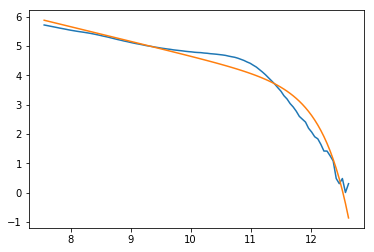

In [232]:
print(res1)
print(res1.success)
print(res1.x)
plt.plot(centers, np.log10(count))
plt.plot(centers, np.log10(
    log_schechter_func(centers, *res1.x)))

## Double Schechter

In [233]:
exp_count = count
bin_centers = centers
def min_func_double(params):
    m_star, alpha1, alpha2, phi_star1, phi_star2 = params
    return np.sum(
        np.power(
            np.log10(log_double_schechter_func(bin_centers, m_star, alpha1, alpha2, phi_star1, phi_star2)) - np.log10(exp_count),
            2,
        )
    )

bounds = [
    (9, 13),
    (-4, 4),
    (-4, 4),
    (2, 8),
    (2, 8),
]

In [234]:
res2 = scipy.optimize.minimize(min_func_double, x0=[g_m_star, g_alpha-0.1, g_alpha, g_phi_star, g_phi_star-2], bounds=bounds, tol=1e-16, method="powell")

/home/christopher/.virtualenvs/hsc_um2/lib/python3.6/site-packages/scipy/optimize/_minimize.py:430: RuntimeWarning: Method powell cannot handle constraints nor bounds.
  RuntimeWarning)


   direc: array([[ 3.27265141e-07,  5.92447479e-07,  9.19141517e-06,  6.43951364e-07, -1.00040327e-05],
       [ 3.59442890e-05, -2.40519749e-05,  1.45038269e-04, -6.46654479e-05, -4.04144004e-04],
       [-5.71352422e-02,  1.71476049e-02,  2.27356243e+00,  8.64082213e-02, -2.14155893e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 2.68296455e-09, -4.05667212e-09, -6.65340288e-08, -9.32778611e-09,  7.46186303e-08]])
     fun: 2.102341276561266
 message: 'Optimization terminated successfully.'
    nfev: 3807
     nit: 24
  status: 0
 success: True
       x: array([11.34460881, -1.37091631,  7.71171754,  3.9465065 , -3.56963991])
[11.34460881 -1.37091631  7.71171754  3.9465065  -3.56963991]


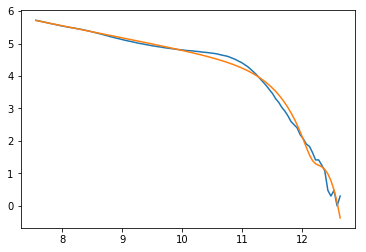

In [235]:
print(res2)
print(res2.x)
r1 = np.log10(log_schechter_func(centers, *res1.x))
r2 = np.log10(log_double_schechter_func(centers, *res2.x))

plt.plot(centers, np.log10(count))
#plt.plot(centers, r1)
plt.plot(centers, r2)
